<a href="https://colab.research.google.com/github/abrazzaq02/ANN-DL/blob/main/Copy_of_LabSession4_Classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Feedforward Networks — Lab Session
### ARI321 — Artificial Neural Networks & Deep Learning

**Topics Covered:**
- Weight Initialization: Xavier vs He
- Batch Normalization
- Vanishing / Exploding Gradients
- Hyperparameter Tuning on MNIST / Fashion-MNIST

>

---
##Install & Import Libraries
We import TensorFlow/Keras for building neural networks, NumPy for arrays, and Matplotlib for plots.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Activation
from tensorflow.keras.initializers import GlorotUniform, HeNormal   # Xavier = Glorot
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import History

print("TensorFlow version:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.19.0
GPU available: True


---
##Choose Your Dataset
Set `USE_FASHION = False` for classic MNIST (handwritten digits 0–9).  
Set `USE_FASHION = True` for Fashion-MNIST (10 clothing categories).

In [ ]:
USE_FASHION = False   # Change to True to use Fashion-MNIST

if USE_FASHION:
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    class_names = ['T-shirt','Trouser','Pullover','Dress','Coat',
                   'Sandal','Shirt','Sneaker','Bag','Ankle boot']
    dataset_name = "Fashion-MNIST"
else:
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    class_names = [str(i) for i in range(10)]
    dataset_name = "MNIST"

print(f"Dataset: {dataset_name}")
print(f"Train samples: {X_train.shape},  Test samples: {X_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Dataset: MNIST
Train samples: (60000, 28, 28),  Test samples: (10000, 28, 28)


---
##Visualize Sample Images
Always look at your data before training. We plot 10 random samples from the training set.

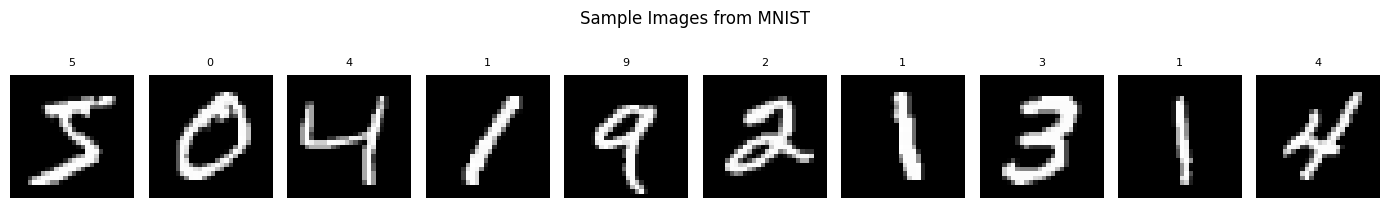

In [ ]:
plt.figure(figsize=(14, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(class_names[y_train[i]], fontsize=8)
    plt.axis('off')
plt.suptitle(f"Sample Images from {dataset_name}", y=1.05)
plt.tight_layout()
plt.show()

---
##Preprocess Data
- **Normalize** pixel values from [0, 255] → [0, 1]. This prevents large input values from causing exploding gradients.
- **Reshape** 28×28 images to flat 784-dimensional vectors (required for Dense layers).
- **One-hot encode** labels: label `3` becomes `[0,0,0,1,0,0,0,0,0,0]`.

In [ ]:
# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

# Flatten 28x28 → 784
X_train_flat = X_train.reshape(-1, 784)
X_test_flat  = X_test.reshape(-1, 784)

# One-hot encode labels
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_ohe  = tf.keras.utils.to_categorical(y_test,  num_classes=10)

print("X_train shape:", X_train_flat.shape)
print("y_train sample (raw vs one-hot):", y_train[0], "→", y_train_ohe[0])

X_train shape: (60000, 784)
y_train sample (raw vs one-hot): 5 → [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


---
##Theory: Vanishing & Exploding Gradients (Demo)
We simulate what happens to gradient magnitudes when the same weight matrix is multiplied many times (deep network without proper initialization).

>**Key insight:** Small weights → gradients shrink to 0 (vanishing). Large weights → gradients blow up (exploding).

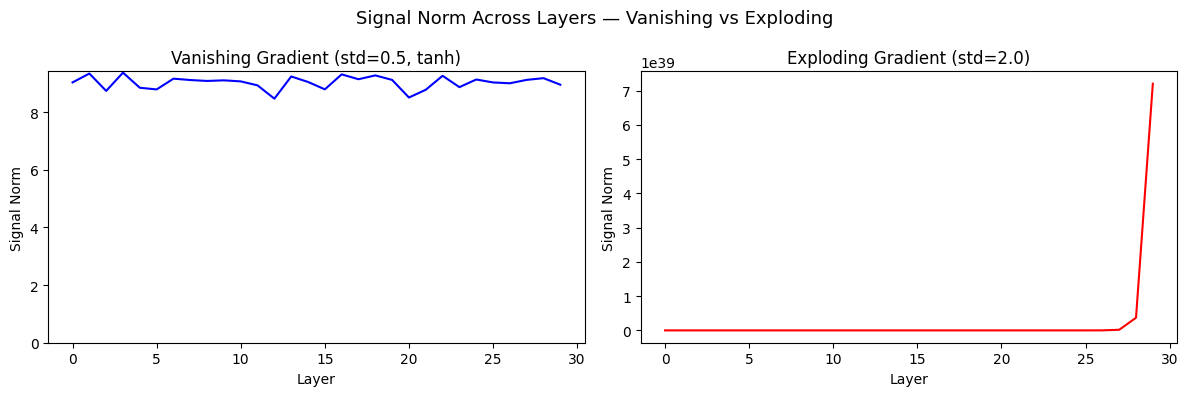

In [ ]:
np.random.seed(42)
n_layers = 30
n_neurons = 100

# --- Vanishing gradient: small random weights ---
signal_small = np.random.randn(n_neurons)
norms_small = []
for _ in range(n_layers):
    W = np.random.randn(n_neurons, n_neurons) * 0.5   # std < 1 → vanishing
    signal_small = np.tanh(W @ signal_small)
    norms_small.append(np.linalg.norm(signal_small))

# --- Exploding gradient: large random weights ---
signal_large = np.random.randn(n_neurons)
norms_large = []
for _ in range(n_layers):
    W = np.random.randn(n_neurons, n_neurons) * 2.0   # std > 1 → exploding
    signal_large = W @ signal_large                   # no activation to show raw blow-up
    norms_large.append(np.linalg.norm(signal_large))

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(norms_small, color='blue')
axes[0].set_title('Vanishing Gradient (std=0.5, tanh)', fontsize=12)
axes[0].set_xlabel('Layer'); axes[0].set_ylabel('Signal Norm')
axes[0].set_ylim(bottom=0)

axes[1].plot(norms_large, color='red')
axes[1].set_title('Exploding Gradient (std=2.0)', fontsize=12)
axes[1].set_xlabel('Layer'); axes[1].set_ylabel('Signal Norm')

plt.suptitle('Signal Norm Across Layers — Vanishing vs Exploding', fontsize=13)
plt.tight_layout()
plt.show()

---
##Theory: Xavier vs He Initialization (Visual Comparison)
**Xavier (Glorot):** Designed for `sigmoid` / `tanh` → variance = `2 / (fan_in + fan_out)`  
**He (Kaiming):** Designed for `ReLU` → variance = `2 / fan_in`  

We visualize the weight distributions both initializations produce.

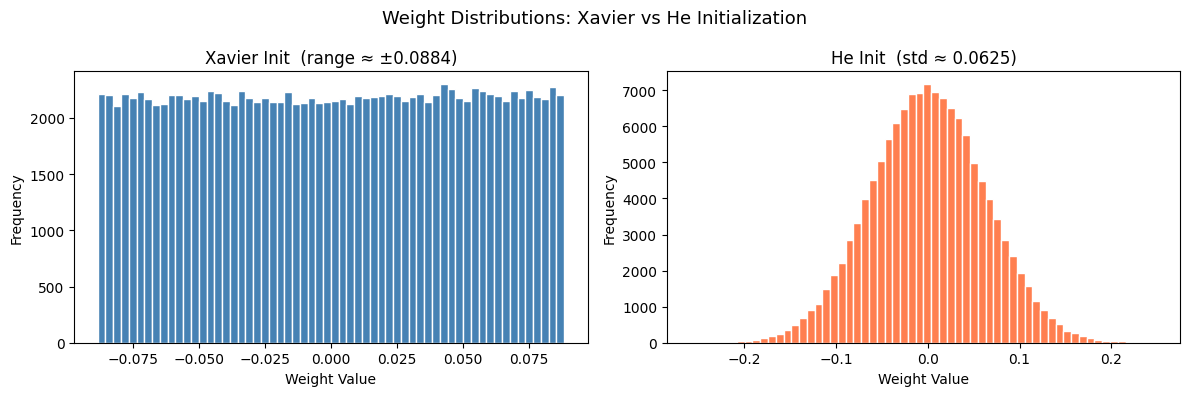

Xavier std: 0.0511
He     std: 0.0625


In [ ]:
fan_in, fan_out = 512, 256

# Xavier / Glorot uniform
limit_xavier = np.sqrt(6 / (fan_in + fan_out))
xavier_weights = np.random.uniform(-limit_xavier, limit_xavier, size=(fan_in, fan_out))

# He normal
std_he = np.sqrt(2 / fan_in)
he_weights = np.random.normal(0, std_he, size=(fan_in, fan_out))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(xavier_weights.flatten(), bins=60, color='steelblue', edgecolor='white')
axes[0].set_title(f'Xavier Init  (range ≈ ±{limit_xavier:.4f})', fontsize=12)
axes[0].set_xlabel('Weight Value'); axes[0].set_ylabel('Frequency')

axes[1].hist(he_weights.flatten(), bins=60, color='coral', edgecolor='white')
axes[1].set_title(f'He Init  (std ≈ {std_he:.4f})', fontsize=12)
axes[1].set_xlabel('Weight Value'); axes[1].set_ylabel('Frequency')

plt.suptitle('Weight Distributions: Xavier vs He Initialization', fontsize=13)
plt.tight_layout()
plt.show()

print(f"Xavier std: {xavier_weights.std():.4f}")
print(f"He     std: {he_weights.std():.4f}")

---
##Experiment 1: Poor Initialization (No strategy)
Using all-zeros initialization — a classic mistake. All neurons learn the same thing (symmetry problem) and gradients vanish.

> This model is expected to perform poorly — that's the point!

In [ ]:
tf.random.set_seed(42)

model_bad = Sequential([
    Dense(256, activation='sigmoid', kernel_initializer='zeros', input_shape=(784,)),
    Dense(128, activation='sigmoid', kernel_initializer='zeros'),
    Dense(64,  activation='sigmoid', kernel_initializer='zeros'),
    Dense(10,  activation='softmax')
])

model_bad.compile(optimizer=SGD(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_bad = model_bad.fit(X_train_flat, y_train_ohe,
                            epochs=10,
                            batch_size=128,
                            validation_split=0.1,
                            verbose=1)

loss_bad, acc_bad = model_bad.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"\n[Zero Init] Test Accuracy: {acc_bad*100:.2f}%  — Expected: ~10% (random guessing)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1019 - loss: 2.3511 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1145 - loss: 2.3013 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1145 - loss: 2.3013 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1145 - loss: 2.3013 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1145 - loss: 2.3013 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1145 - loss: 2.3013 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1145 - loss: 2.3013 - val_accuracy: 0.1050 - val_loss: 2.3020
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1145 - loss: 2.3013 - val_accuracy: 0.

---
##Experiment 2: Xavier Initialization + Sigmoid
Xavier init is designed for sigmoid/tanh activations. The variance is scaled to keep gradients stable across layers.

In [ ]:
tf.random.set_seed(42)

model_xavier = Sequential([
    Dense(256, activation='sigmoid', kernel_initializer='glorot_uniform', input_shape=(784,)),
    Dense(128, activation='sigmoid', kernel_initializer='glorot_uniform'),
    Dense(64,  activation='sigmoid', kernel_initializer='glorot_uniform'),
    Dense(10,  activation='softmax')
])

model_xavier.compile(optimizer=SGD(learning_rate=0.01),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_xavier = model_xavier.fit(X_train_flat, y_train_ohe,
                                  epochs=15,
                                  batch_size=128,
                                  validation_split=0.1,
                                  verbose=1)

loss_xavier, acc_xavier = model_xavier.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"\n[Xavier + Sigmoid] Test Accuracy: {acc_xavier*100:.2f}%")

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1148 - loss: 2.3580 - val_accuracy: 0.1050 - val_loss: 2.2993
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1169 - loss: 2.2976 - val_accuracy: 0.1050 - val_loss: 2.2954
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1186 - loss: 2.2938 - val_accuracy: 0.1050 - val_loss: 2.2913
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1203 - loss: 2.2898 - val_accuracy: 0.1050 - val_loss: 2.2867
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1232 - loss: 2.2853 - val_accuracy: 0.1050 - val_loss: 2.2815
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1289 - loss: 2.2801 - val_accuracy: 0.1105 - val_loss: 2.2755
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1431 - loss: 2.2740 - val_accuracy: 0.1398 - val_loss: 2.2682
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1709 - loss: 2.2666 - val_accuracy: 0.

---
##Experiment 3: He Initialization + ReLU
He init is designed for ReLU. ReLU kills ~half the neurons (outputs 0 for negative inputs), so we need larger initial weights to maintain signal strength.

In [ ]:
tf.random.set_seed(42)

model_he = Sequential([
    Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(784,)),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    Dense(64,  activation='relu', kernel_initializer='he_normal'),
    Dense(10,  activation='softmax')
])

model_he.compile(optimizer=SGD(learning_rate=0.01),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

history_he = model_he.fit(X_train_flat, y_train_ohe,
                          epochs=15,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=1)

loss_he, acc_he = model_he.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"\n[He + ReLU] Test Accuracy: {acc_he*100:.2f}%")

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5381 - loss: 1.5703 - val_accuracy: 0.8920 - val_loss: 0.4332
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8766 - loss: 0.4515 - val_accuracy: 0.9218 - val_loss: 0.2889
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9064 - loss: 0.3303 - val_accuracy: 0.9348 - val_loss: 0.2402
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9183 - loss: 0.2797 - val_accuracy: 0.9425 - val_loss: 0.2124
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9275 - loss: 0.2483 - val_accuracy: 0.9477 - val_loss: 0.1928
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9341 - loss: 0.2254 - val_accuracy: 0.9525 - val_loss: 0.1782
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9402 - loss: 0.2074 - val_accuracy: 0.9547 - val_loss: 0.1667
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9447 - loss: 0.1926 - val_accuracy: 0.

---
##Experiment 4: He Init + ReLU + Batch Normalization
**Batch Normalization** normalizes the output of each layer before activation. Benefits:
- Reduces internal covariate shift
- Allows higher learning rates
- Acts as mild regularization
- Largely solves the vanishing gradient problem in deep networks

Note: When using BatchNorm, we add it **before** the activation.

In [ ]:
tf.random.set_seed(42)

model_bn = Sequential([
    # Layer 1
    Dense(256, kernel_initializer='he_normal', input_shape=(784,)),
    BatchNormalization(),      # Normalize before activation
    Activation('relu'),

    # Layer 2
    Dense(128, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),

    # Layer 3
    Dense(64, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),

    # Output layer
    Dense(10, activation='softmax')
])

model_bn.compile(optimizer=SGD(learning_rate=0.05),   # BatchNorm allows higher LR
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model_bn.summary()

history_bn = model_bn.fit(X_train_flat, y_train_ohe,
                          epochs=15,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=1)

loss_bn, acc_bn = model_bn.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"\n[He + ReLU + BatchNorm] Test Accuracy: {acc_bn*100:.2f}%")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,554 (955.29 KB)

 Trainable params: 243,658 (951.79 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7952 - loss: 0.7404 - val_accuracy: 0.9582 - val_loss: 0.1660
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9497 - loss: 0.1776 - val_accuracy: 0.9690 - val_loss: 0.1130
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9669 - loss: 0.1154 - val_accuracy: 0.9740 - val_loss: 0.0950
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9776 - loss: 0.0823 - val_accuracy: 0.9763 - val_loss: 0.0864
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9845 - loss: 0.0607 - val_accuracy: 0.9757 - val_loss: 0.0823
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9904 - loss: 0.0453 - val_accuracy: 0.9763 - val_loss: 0.0792
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9943 - loss: 0.0340 - val_accuracy: 0.9772 - val_loss: 0.0776
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0257 - val_accuracy: 0.

---
##Compare All Models
Side-by-side comparison of training curves and final test accuracies for all 4 experiments.

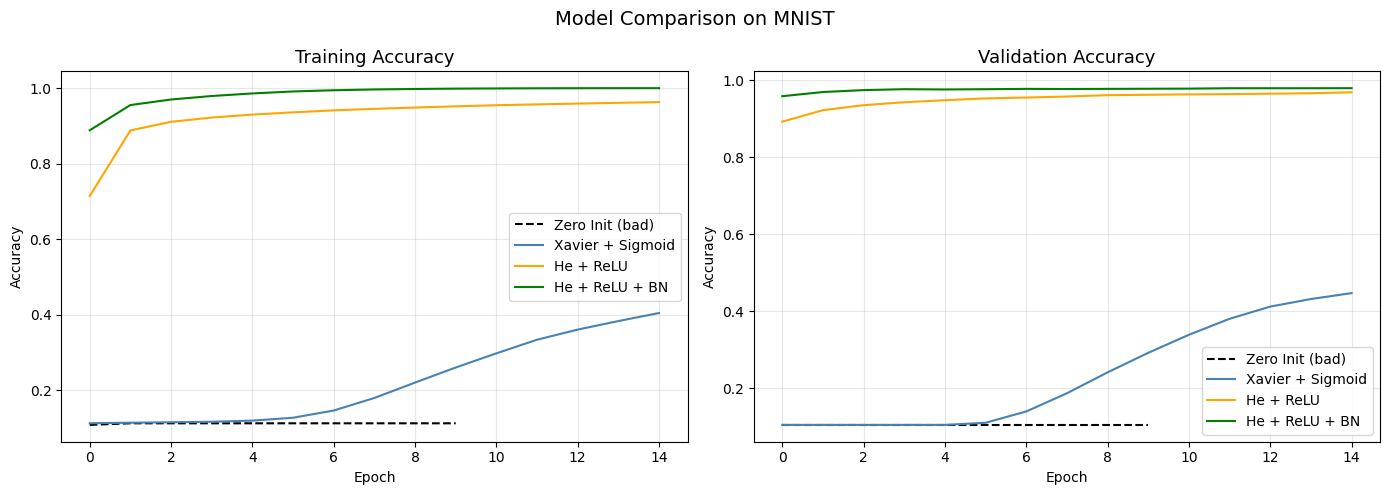

Model                            Test Accuracy
--------------------------------------------------
Zero Init (bad)                         11.35%
Xavier + Sigmoid                        43.78%
He + ReLU                               95.95%
He + ReLU + BatchNorm                   97.73%


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Training Accuracy ---
axes[0].plot(history_bad.history['accuracy'],    label='Zero Init (bad)',   color='black',    linestyle='--')
axes[0].plot(history_xavier.history['accuracy'], label='Xavier + Sigmoid',  color='steelblue')
axes[0].plot(history_he.history['accuracy'],     label='He + ReLU',         color='orange')
axes[0].plot(history_bn.history['accuracy'],     label='He + ReLU + BN',    color='green')
axes[0].set_title('Training Accuracy', fontsize=13)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# --- Validation Accuracy ---
axes[1].plot(history_bad.history['val_accuracy'],    label='Zero Init (bad)',   color='black',    linestyle='--')
axes[1].plot(history_xavier.history['val_accuracy'], label='Xavier + Sigmoid',  color='steelblue')
axes[1].plot(history_he.history['val_accuracy'],     label='He + ReLU',         color='orange')
axes[1].plot(history_bn.history['val_accuracy'],     label='He + ReLU + BN',    color='green')
axes[1].set_title('Validation Accuracy', fontsize=13)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Model Comparison on {dataset_name}', fontsize=14)
plt.tight_layout()
plt.show()

# --- Summary Table ---
print("=" * 50)
print(f"{'Model':<30} {'Test Accuracy':>15}")
print("-" * 50)
print(f"{'Zero Init (bad)':<30} {acc_bad*100:>14.2f}%")
print(f"{'Xavier + Sigmoid':<30} {acc_xavier*100:>14.2f}%")
print(f"{'He + ReLU':<30} {acc_he*100:>14.2f}%")
print(f"{'He + ReLU + BatchNorm':<30} {acc_bn*100:>14.2f}%")
print("=" * 50)

---
##Hyperparameter Tuning (Manual Grid Search)
We try different combinations of **learning rate** and **batch size** to see their effect on the best model (He + BN).

> This is a simplified grid search — no loops with functions, everything is written out step by step.

In [ ]:
EPOCHS = 10   # Keep short for tuning speed

# ----- Config 1: LR=0.001, Batch=32 -----
tf.random.set_seed(42)
m1 = Sequential([
    Dense(256, kernel_initializer='he_normal', input_shape=(784,)), BatchNormalization(), Activation('relu'),
    Dense(128, kernel_initializer='he_normal'), BatchNormalization(), Activation('relu'),
    Dense(10, activation='softmax')
])
m1.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
h1 = m1.fit(X_train_flat, y_train_ohe, epochs=EPOCHS, batch_size=32, validation_split=0.1, verbose=0)
_, a1 = m1.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"Config 1 — LR=0.001, Batch=32,  Adam  → Test Acc: {a1*100:.2f}%")

# ----- Config 2: LR=0.001, Batch=128 -----
tf.random.set_seed(42)
m2 = Sequential([
    Dense(256, kernel_initializer='he_normal', input_shape=(784,)), BatchNormalization(), Activation('relu'),
    Dense(128, kernel_initializer='he_normal'), BatchNormalization(), Activation('relu'),
    Dense(10, activation='softmax')
])
m2.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
h2 = m2.fit(X_train_flat, y_train_ohe, epochs=EPOCHS, batch_size=128, validation_split=0.1, verbose=0)
_, a2 = m2.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"Config 2 — LR=0.001, Batch=128, Adam  → Test Acc: {a2*100:.2f}%")

# ----- Config 3: LR=0.01, Batch=128 -----
tf.random.set_seed(42)
m3 = Sequential([
    Dense(256, kernel_initializer='he_normal', input_shape=(784,)), BatchNormalization(), Activation('relu'),
    Dense(128, kernel_initializer='he_normal'), BatchNormalization(), Activation('relu'),
    Dense(10, activation='softmax')
])
m3.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h3 = m3.fit(X_train_flat, y_train_ohe, epochs=EPOCHS, batch_size=128, validation_split=0.1, verbose=0)
_, a3 = m3.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"Config 3 — LR=0.01,  Batch=128, Adam  → Test Acc: {a3*100:.2f}%")

# ----- Config 4: LR=0.05, Batch=256, SGD -----
tf.random.set_seed(42)
m4 = Sequential([
    Dense(256, kernel_initializer='he_normal', input_shape=(784,)), BatchNormalization(), Activation('relu'),
    Dense(128, kernel_initializer='he_normal'), BatchNormalization(), Activation('relu'),
    Dense(10, activation='softmax')
])
m4.compile(optimizer=SGD(0.05), loss='categorical_crossentropy', metrics=['accuracy'])
h4 = m4.fit(X_train_flat, y_train_ohe, epochs=EPOCHS, batch_size=256, validation_split=0.1, verbose=0)
_, a4 = m4.evaluate(X_test_flat, y_test_ohe, verbose=0)
print(f"Config 4 — LR=0.05,  Batch=256, SGD   → Test Acc: {a4*100:.2f}%")

Config 1 — LR=0.001, Batch=32,  Adam  → Test Acc: 98.20%
Config 2 — LR=0.001, Batch=128, Adam  → Test Acc: 98.02%
Config 3 — LR=0.01,  Batch=128, Adam  → Test Acc: 97.91%
Config 4 — LR=0.05,  Batch=256, SGD   → Test Acc: 97.15%


---
##Hyperparameter Tuning Results — Plot
Compare the validation accuracy curves across all 4 hyperparameter configurations.

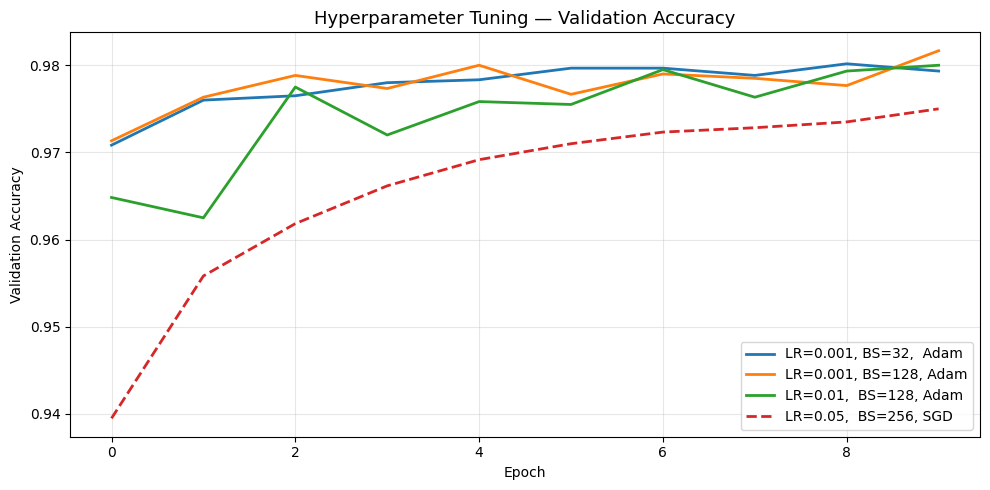


Best Config: LR=0.001/BS=32/Adam  →  98.20%


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(h1.history['val_accuracy'], label='LR=0.001, BS=32,  Adam',  linewidth=2)
plt.plot(h2.history['val_accuracy'], label='LR=0.001, BS=128, Adam',  linewidth=2)
plt.plot(h3.history['val_accuracy'], label='LR=0.01,  BS=128, Adam',  linewidth=2)
plt.plot(h4.history['val_accuracy'], label='LR=0.05,  BS=256, SGD',   linewidth=2, linestyle='--')

plt.title('Hyperparameter Tuning — Validation Accuracy', fontsize=13)
plt.xlabel('Epoch'); plt.ylabel('Validation Accuracy')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

accs = [a1, a2, a3, a4]
labels = ['LR=0.001/BS=32/Adam', 'LR=0.001/BS=128/Adam', 'LR=0.01/BS=128/Adam', 'LR=0.05/BS=256/SGD']
best_idx = np.argmax(accs)
print(f"\nBest Config: {labels[best_idx]}  →  {accs[best_idx]*100:.2f}%")

---
##Visualize Predictions from the Best Model
Check which samples the best model gets right and which ones it misclassifies.

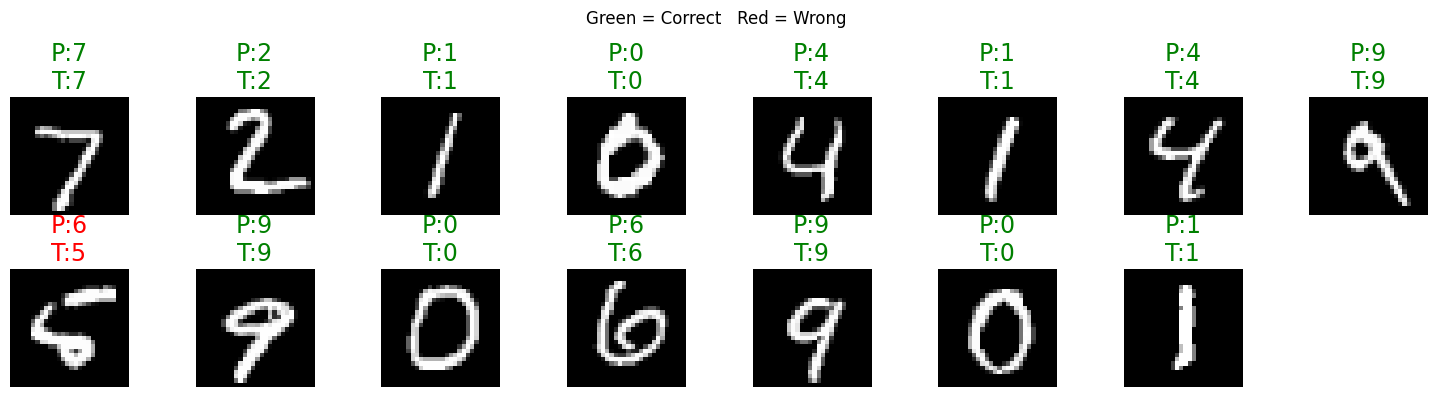

In [ ]:
# Select best model (Config 2 is usually best — adjust if needed)
best_model = m2

# Get predictions on test set
y_pred_probs = best_model.predict(X_test_flat, verbose=0)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Plot 15 test samples with predicted vs true label
plt.figure(figsize=(15, 4))
for i in range(15):
    plt.subplot(2, 8, i+1) if i < 8 else plt.subplot(2, 8, i+1)
    plt.subplot(2, 8, i+1)
    plt.imshow(X_test[i], cmap='gray')
    color = 'green' if y_pred_labels[i] == y_test[i] else 'red'
    plt.title(f"P:{class_names[y_pred_labels[i]]}\nT:{class_names[y_test[i]]}",
              fontsize=17, color=color)
    plt.axis('off')
plt.suptitle('Green = Correct   Red = Wrong ', fontsize=12)
plt.tight_layout()
plt.show()

---
##Gradient Flow Visualization (Weight Gradients per Layer)
We extract the gradient magnitudes from our best-trained model to confirm that batch normalization successfully prevents vanishing gradients.

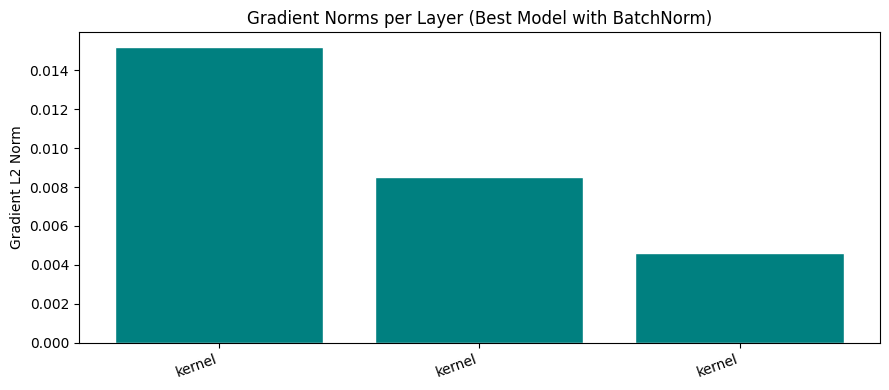


Gradient norms (healthy range is > 1e-4):
  kernel                         norm = 0.015202  Correct
  kernel                         norm = 0.008511  Correct
  kernel                         norm = 0.004585  Correct


In [ ]:
import tensorflow as tf

# Use a small batch to compute gradients
X_sample = tf.constant(X_train_flat[:128], dtype=tf.float32)
y_sample = tf.constant(y_train_ohe[:128], dtype=tf.float32)

with tf.GradientTape() as tape:
    y_hat = best_model(X_sample, training=True)
    loss  = tf.keras.losses.categorical_crossentropy(y_sample, y_hat)
    loss  = tf.reduce_mean(loss)

grads = tape.gradient(loss, best_model.trainable_variables)

# Collect gradient norms for Dense weight matrices only
grad_norms = []
layer_labels = []
for var, grad in zip(best_model.trainable_variables, grads):
    if 'kernel' in var.name and grad is not None:
        grad_norms.append(tf.norm(grad).numpy())
        layer_labels.append(var.name.split('/')[0])

plt.figure(figsize=(9, 4))
plt.bar(range(len(grad_norms)), grad_norms, color='teal', edgecolor='white')
plt.xticks(range(len(grad_norms)), layer_labels, rotation=20, ha='right')
plt.ylabel('Gradient L2 Norm')
plt.title('Gradient Norms per Layer (Best Model with BatchNorm)', fontsize=12)
plt.tight_layout()
plt.show()

print("\nGradient norms (healthy range is > 1e-4):")
for name, norm in zip(layer_labels, grad_norms):
    status = 'Correct' if norm > 1e-4 else 'Vanishing!'
    print(f"  {name:<30} norm = {norm:.6f}  {status}")


### Tasks
1. Switch `USE_FASHION = True` and re-run all experiments. How does accuracy change?
2. Try adding a **4th hidden layer** to the He+BN model. Does accuracy improve?
3. Replace `Adam` with `RMSprop`. Compare convergence speed.
4. Add **Dropout(0.3)** after each BatchNorm layer. Does it help with overfitting?